In [26]:
import serial
import sys
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.transform import Rotation as R

import math

def haversine(lat1, lon1, lat2, lon2):
      R = 6372.8 #km
      dLat = math.radians(lat2 - lat1)
      dLon = math.radians(lon2 - lon1)
      lat1 = math.radians(lat1)
      lat2 = math.radians(lat2)
      a = math.sin(dLat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dLon/2)**2
      c = 2*math.asin(math.sqrt(a))
      return R * c

def bearing(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    Bearing = math.atan2(math.sin(dlon)*math.cos(lat2), 
                         math.cos(lat1)*math.sin(lat2)-math.sin(lat1)*math.cos(lat2)*math.cos(dlon))

    return Bearing

def get_serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

def extract_lon(l):
    l = str(l)
    # print("lon: ", l)
    return -float(l[:3]) - float(l[3:])/60.0 

def extract_lat(l):
    l = str(l)
    # print("lat: ", l)
    return float(l[:2]) + float(l[2:])/60.0 

def test_port(s_port, bauds=[115200]):
    ser = serial.Serial()
    ser_open = False
    attempts = 0

    #attempt to connect
    while not ser_open and attempts < 5:
        for baud in bauds:
            try:
                ser = serial.Serial(s_port, baud, timeout=3)
                print(s_port, " opened succesfully at ", baud)
                print(ser.read(10))
                ser_open = True
            except:
                print("Failed to open ",s_port, " serial port: ", attempts)
                
            if not ser_open:
                time.sleep(0.5)
                attempts += 1

    if ser_open:
        ser.close()

def match_ports(s_ports, bauds=[115200]):

    port_dict = dict()

    for s_port in s_ports:
        ser = serial.Serial()
        ser_open = False
        attempts = 0

        #attempt to connect
        while not ser_open and attempts < 5:
            for baud in bauds:
                try:
                    ser = serial.Serial(s_port, baud, timeout=3)
                    # print(s_port, " opened succesfully at ", baud)
                    bytes = ser.read(10)
                    header = str(bytes[0:len(bytes)-2].decode("utf-8"))
                    # print("header: ", header)
                    ser_open = True
                    if 'PWM' in header:
                        # print("PWM is: ", s_port)
                        port_dict['PWM'] = s_port
                    elif '$G' in header:
                        # print("GPS is: ", s_port)
                        port_dict['GPS'] = s_port
                    elif 'Artemis' in header or 'Logging' in header:
                        # print("OLA is: ", s_port)
                        port_dict['OLA'] = s_port

                except:
                    print("Failed to open ",s_port, " serial port: ", attempts)
                    
                if not ser_open:
                    time.sleep(0.5)
                    attempts += 1
        ser.close()

    print("port_dict[PWM]: ", port_dict["PWM"])
    print("port_dict[OLA]: ", port_dict["OLA"])
    print("port_dict[GPS]: ", port_dict["GPS"])

    return port_dict

class Serial_Interface:
    def __init__(self, name, cols, types, proc_string_fun, port_dict, baud=115200):
        self.name = name
        self.cols = cols
        self.types = types
        self.df = pd.DataFrame(columns=cols)
        self.ser = serial.Serial()
        ser_open = False
        attempts = 0
        self.process_strings_fun = proc_string_fun
        self.s_port = port_dict[name]

        #attempt to connect
        while not ser_open and attempts < 5:
            try:
                self.ser = serial.Serial(self.s_port, baud, timeout=None)
                ser_open = True
            except:
                print("Failed to open ", name, " serial port at: ", self.s_port, " in ", attempts, " attempts")
                
            if not ser_open:
                time.sleep(0.5)
                attempts += 1
                
    def check_and_log(self, c_time):
        if self.ser.in_waiting:
            bytes =self.ser.readline()
            # print("gps: ", gps_bytes)
            try:
                decoded_strings = str(bytes[0:len(bytes)-2].decode("utf-8")).split(',')
                # print("Serial_Interface: check and log: coded strings: ", decoded_strings)
                out_success, out = self.process_strings_fun(decoded_strings, c_time, self.types)
                if out_success:
                    self.df.loc[len(self.df)] = out
                    
            except:
                print(self.name, " had a logging error")
                
    def close_and_save(self):
        self.ser.close()
        
    def flush_logs(self):
        self.ser.flushInput()
        self.df = pd.DataFrame(columns=self.cols)
        



In [2]:
gps_cols = ['Wall_Time',
    'header',
    'utc time',
    'Lat',
    'Lat_Dir',
    'Lon',
    'Lon _Dir',
    'Quality_Indicator',
    'Satellites Used',
    'HDOP',
    'Altitude',
    'Alt_units',
    'Geoidal_Separation',
    'GS_units',
    'DGPS_Station_ID',
    'checksum']

gps_types = [str, # header
        float, # utc time
        str, # lat
        str, # lat dir
        str, # lon
        str, # lon dir
        int, # quality indicator
        int, # N satellites
        float, # hdop
        float, # altitude
        str, # alt units
        float, #geoidal separation
        str, # gs units
        str, # dpgs station id
        str] # check sum

def gps_proc_string(decoded_strings, c_time, gps_types):
    # print("GPS string: ", decoded_strings[0])
    if decoded_strings[0] == '$GNGGA':
        out = [ty(st) for st, ty in zip(decoded_strings, gps_types)]
        out[2] = extract_lat(out[2])
        out[4] = extract_lon(out[4])
        out.insert(0, c_time)
        # print("gps_out: ", out)
        return True, out
    return False, []

# gps_log = Serial_Interface('GPS', gps_cols, gps_types, gps_proc_string, port_dict)
# gps_log.flush_logs()

# start = time.time()
# max_time = 10.0
# c_time = time.time() - start
# while c_time < max_time:
#     c_time = time.time() - start
#     gps_log.check_and_log(c_time)

# gps_log.close_and_save()
# gps_log.df.head()

In [3]:
ola_cols = ['Wall_Time',
        'rtcDate',
        'rtcTime',
        'Q9_1',
        'Q9_2',
        'Q9_3',
        'HeadAcc',
        'RawAX',
        'RawAY',
        'RawAZ',
        'RawGX',
        'RawGY',
        'RawGZ',
        'RawMX',
        'RawMY',
        'RawMZ',
        'output_Hz']

ola_types = [str, # rtcDate - 01/01/2000
        str, # rtcTime - 07:24:04.91
        float, # q1
        float, # q2
        float, # q3
        float, # head acc
        float, # raw ax 
        float, # raw ay
        float, # raw az
        float, # raw gx
        float, # raw gy
        float, # raw gz
        float, # raw mx  
        float, # raw my
        float, # raw mz 
        float] # output_Hz

def ola_proc_string(decoded_strings, c_time, ola_types):
    # print("decoded_strings: ", decoded_strings)
    if decoded_strings[0] == '01/01/2000':
        out = [ty(st) for st, ty in zip(decoded_strings, ola_types)]
        out.insert(0, c_time)
        # print("ola_out: ", out)
        return True, out
    return False, []


# ola_log = Serial_Interface("OLA", ola_cols, ola_types, ola_proc_string, port_dict)
# ola_log.flush_logs()

# start = time.time()
# max_time = 10.0
# c_time = time.time() - start
# while c_time < max_time:
#     c_time = time.time() - start
#     ola_log.check_and_log(c_time)

# ola_log.close_and_save()
# ola_log.df.head()


In [4]:
pwm_cols = ['Wall_Time',
        'Header',
        'Status',
        'Steer',
        'Throttle']

pwm_types = [str,
             float,
             float, # steer
             float] # throttle
    
def pwm_proc_string(decoded_strings, c_time, pwm_types):
    # print("decoded PWM strings: " , decoded_strings)
    out = [ty(st) for st, ty in zip(decoded_strings, pwm_types)]
    out.insert(0, c_time)
    return True, out
        
# pwm_log = Serial_Interface("PWM", pwm_cols, pwm_types, pwm_proc_string, port_dict)
# pwm_log.flush_logs()

# start = time.time()
# max_time = 10.0
# c_time = time.time() - start
# while c_time < max_time:
#     c_time = time.time() - start
#     pwm_log.check_and_log(c_time)

# pwm_log.close_and_save()
# pwm_log.df.head()


In [5]:
print(get_serial_ports())
# for port in ports:
#     test_port(port)

['/dev/ttyUSB2', '/dev/ttyUSB0', '/dev/ttyACM0', '/dev/ttyTHS4', '/dev/ttyTHS1']


In [33]:
print("Checking available USB ports...")
ports = get_serial_ports()
print("found ports: ", ports)
print("Matching sensors to ports...")
port_dict = match_ports(ports)

print("Setting up serial connections...")
ola_log = Serial_Interface("OLA", ola_cols, ola_types, ola_proc_string, port_dict)
gps_log = Serial_Interface("GPS", gps_cols, gps_types, gps_proc_string, port_dict)
pwm_log = Serial_Interface("PWM", pwm_cols, pwm_types, pwm_proc_string, port_dict)
print("Established Serial Connections")

print("Flushing data logs...")
ola_log.flush_logs()
gps_log.flush_logs()
pwm_log.flush_logs()

print("Starting logging...")
start = time.time()
max_time = 300.0
c_time = 0.0
cnt = 0
while c_time < max_time:
    cnt += 1
    c_time = time.time() - start
    ola_log.check_and_log(c_time)
    gps_log.check_and_log(c_time)
    pwm_log.check_and_log(c_time)
    if cnt % 100 == 0:
        print("Logging at ", c_time, " seconds...")
        print("Logged :OLA - ", len(ola_log.df), " -GPS - ", len(gps_log.df), " -PWM - ", len(pwm_log.df))

print("counter: ", cnt, " = ", cnt / max_time, " Hz")

ola_log.close_and_save()
gps_log.close_and_save()
pwm_log.close_and_save()

Checking available USB ports...
found ports:  ['/dev/ttyUSB2', '/dev/ttyUSB0', '/dev/ttyACM0', '/dev/ttyTHS4', '/dev/ttyTHS1']
Matching sensors to ports...
port_dict[PWM]:  /dev/ttyUSB0
port_dict[OLA]:  /dev/ttyUSB2
port_dict[GPS]:  /dev/ttyACM0
Setting up serial connections...
Established Serial Connections
Flushing data logs...
Starting logging...
Logging at  0.004163265228271484  seconds...
Logged :OLA -  0  -GPS -  0  -PWM -  0
Logging at  0.009408235549926758  seconds...
Logged :OLA -  0  -GPS -  0  -PWM -  0
Logging at  0.01444864273071289  seconds...
Logged :OLA -  0  -GPS -  0  -PWM -  0
Logging at  0.020803213119506836  seconds...
Logged :OLA -  0  -GPS -  0  -PWM -  0
Logging at  0.02672266960144043  seconds...
Logged :OLA -  0  -GPS -  0  -PWM -  0
Logging at  0.031066179275512695  seconds...
Logged :OLA -  0  -GPS -  0  -PWM -  0
Logging at  0.03545522689819336  seconds...
Logged :OLA -  0  -GPS -  0  -PWM -  0
Logging at  0.03989720344543457  seconds...
Logged :OLA -  0  -

,Wall_Time,Header,Status,Steer,Throttle
0,1.512107,PWM,0.0,-1.0,-1.0
1,2.516492,PWM,1.0,1500.0,1476.0
2,2.576381,PWM,1.0,1500.0,1476.0
3,2.626979,PWM,1.0,1496.0,1472.0
4,2.677469,PWM,1.0,1496.0,1472.0


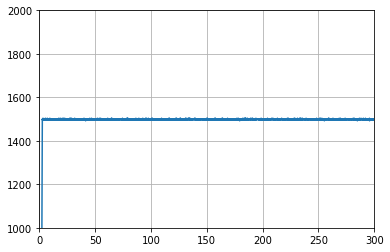

In [34]:
display(pwm_log.df.head())
plt.plot(pwm_log.df['Wall_Time'], pwm_log.df['Steer'])
plt.grid()
plt.axis([0, pwm_log.df['Wall_Time'].max(), 1000, 2000])
plt.show()

In [8]:
pwm_log.df.to_pickle("/home/andy/autopilot/not-so-dumb-rc-car/AutonomousCar/code/pwm_data.pkl")

In [35]:
m_lon = gps_log.df["Lon"].mean()
m_lat = gps_log.df["Lat"].mean()

print("Mean Lat \ Lon: ", m_lat, " \ ", m_lon)

gps_log.df["dist2center"] = gps_log.df.apply(lambda x: 1000.0 * haversine(x["Lat"], x["Lon"], m_lat, m_lon), axis=1)
gps_log.df["bearing2center"] = gps_log.df.apply(lambda x: bearing(m_lat, m_lon, x["Lat"], x["Lon"]), axis=1)
gps_log.df["x"] = gps_log.df.apply(lambda x: math.sin(x["bearing2center"]) * x["dist2center"], axis=1)
gps_log.df["y"] = gps_log.df.apply(lambda x: math.cos(x["bearing2center"]) * x["dist2center"], axis=1)
display(gps_log.df.head())

Mean Lat \ Lon:  39.426660350658864  \  -119.80314501366519


,Wall_Time,header,utc time,Lat,Lat_Dir,Lon,Lon _Dir,Quality_Indicator,Satellites Used,HDOP,Altitude,Alt_units,Geoidal_Separation,GS_units,DGPS_Station_ID,checksum,dist2center,bearing2center,x,y
0,0.115754,$GNGGA,223300.4,39.426663,N,-119.803138,W,2,12,0.88,1481.6,M,-24.0,M,,0000*4B,0.687870,1.067531,0.602582,0.331752
1,0.310444,$GNGGA,223300.6,39.426664,N,-119.803138,W,2,12,0.88,1481.6,M,-24.0,M,,0000*44,0.740602,1.020381,0.631221,0.387365
2,0.506181,$GNGGA,223300.8,39.426665,N,-119.803137,W,2,12,0.88,1481.5,M,-24.0,M,,0000*47,0.827628,0.952024,0.674179,0.480054
3,0.698297,$GNGGA,223301.0,39.426665,N,-119.803137,W,2,12,0.88,1481.4,M,-24.0,M,,0000*44,0.872568,0.936449,0.702817,0.517129
4,0.913384,$GNGGA,223301.2,39.426665,N,-119.803137,W,2,12,0.88,1481.4,M,-24.0,M,,0000*47,0.884142,0.946047,0.717136,0.517129


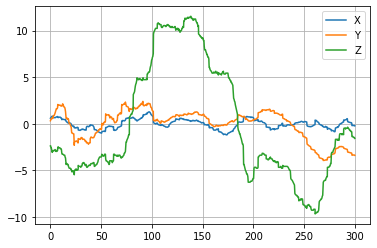

In [36]:
# display(df)

plt.plot(gps_log.df.Wall_Time, gps_log.df.x, label='X')
plt.plot(gps_log.df.Wall_Time, gps_log.df.y, label='Y')
plt.plot(gps_log.df.Wall_Time, gps_log.df.Altitude - gps_log.df["Altitude"].mean(), label='Z')
plt.grid()
plt.legend()
plt.show()

,Wall_Time,rtcDate,rtcTime,Q9_1,Q9_2,Q9_3,HeadAcc,RawAX,RawAY,RawAZ,RawGX,RawGY,RawGZ,RawMX,RawMY,RawMZ,output_Hz,Yaw,Pitch,Roll
0,3.299094,01/01/2000,22:56:33.13,0.00733,0.00274,-0.01181,330.0,-176.0,-50.0,-7906.0,19.0,0.0,-43.0,126.0,-80.0,-226.0,14.286,-1.355638,0.304031,0.843622
1,3.364067,01/01/2000,22:56:33.23,0.00783,0.00297,-0.01255,330.0,-116.0,-82.0,-7900.0,28.0,10.0,-38.0,107.0,-86.0,-214.0,18.182,-1.440801,0.329039,0.901473
2,3.400022,01/01/2000,22:56:33.25,0.00807,0.00308,-0.01291,330.0,-156.0,0.0,-7978.0,23.0,7.0,-38.0,106.0,-83.0,-223.0,25.000,-1.482238,0.340963,0.929256
3,3.421317,01/01/2000,22:56:33.26,0.00834,0.00322,-0.01330,330.0,-174.0,-46.0,-7960.0,26.0,10.0,-42.0,121.0,-80.0,-245.0,30.769,-1.527160,0.356229,0.960542
4,3.454356,01/01/2000,22:56:33.27,0.00834,0.00322,-0.01330,330.0,-174.0,-46.0,-7960.0,26.0,10.0,-42.0,121.0,-80.0,-245.0,35.714,-1.527160,0.356229,0.960542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9406,299.848713,01/01/2000,22:58:20.12,0.47903,0.87774,-0.00852,349.0,-130.0,-58.0,-7930.0,26.0,4.0,-39.0,122.0,-89.0,-232.0,87.924,-122.751793,0.084699,178.841498
9407,299.885781,01/01/2000,22:58:20.13,0.47894,0.87779,-0.00852,349.0,-156.0,-68.0,-7960.0,25.0,5.0,-37.0,116.0,-85.0,-233.0,87.925,-122.763741,0.070350,178.849402
9408,299.949646,01/01/2000,22:58:20.14,0.47894,0.87779,-0.00852,349.0,-156.0,-68.0,-7960.0,25.0,5.0,-37.0,116.0,-85.0,-233.0,87.926,-122.763741,0.070350,178.849402
9409,299.988630,01/01/2000,22:58:20.15,0.47893,0.87779,-0.00853,349.0,-134.0,-94.0,-7950.0,25.0,4.0,-43.0,124.0,-77.0,-233.0,87.927,-122.763866,0.152007,178.803543


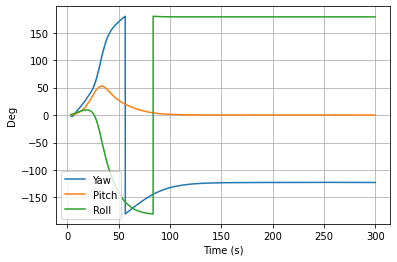

In [37]:
yaws = []
pitches = []
rolls = []
for row in ola_log.df.itertuples():
    qx = row.Q9_1
    qy = row.Q9_2
    qz = row.Q9_3
    qw = math.sqrt( 1.0 - (qx**2 + qy**2 + qz**2))
    
    r = R.from_quat([qx, qy, qz, qw])
    ypr = r.as_euler('zyx', degrees=True)
    
    yaws.append(ypr[0])
    pitches.append(ypr[1])
    rolls.append(ypr[2])
    
ola_log.df['Yaw'] = yaws
ola_log.df['Pitch'] = pitches
ola_log.df['Roll'] = rolls

display(ola_log.df)

plt.plot(ola_log.df.Wall_Time, ola_log.df.Yaw, label='Yaw')
plt.plot(ola_log.df.Wall_Time, ola_log.df.Pitch, label='Pitch')
plt.plot(ola_log.df.Wall_Time, ola_log.df.Roll, label='Roll')
plt.xlabel('Time (s)')
plt.ylabel('Deg')
plt.grid()
plt.legend()
plt.show()